In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
from gensim.models import Word2Vec
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

basic recommendation system models for a Fashion e-commerce platform

The fashion e-commerce platform currently collects various data points from customer transactions over a 1 month period and has a database of its fashion products. You will be provided with 2 datasets.
1. Transactions dataset (transactions_train.csv) which represents all the transactions made in the store.
2. Articles dataset (articles.csv) which represents all the items found in its catalog.

downloaded directly from https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data **(transactions_train.csv and articles.csv)**


In [4]:
# Uncomment to mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Read csv file from a directory into pandas DataFrame
# Modify directory if needed

df_a = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/articles.csv")
df_t = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/transactions_train.csv")

In [6]:
# DO NOT MODIFY ANY OF THE CODE FOUND IN THIS BLOCK. Just run this code block.
# Ensuring that 't_dat' is in date time format
df_t['t_dat'] = pd.to_datetime(df_t['t_dat'], format="%Y-%m-%d")

# Filtering transactions data to 1 month period
df_t = df_t[(df_t['t_dat'] >= '2019-09-20') & (df_t['t_dat'] <= '2019-10-20')]

# Filtering articles dataset
df_a = df_a[df_a['article_id'].isin(df_t['article_id'].unique())]

# Keeping columns required for assignment
columns_to_keep_a = ['article_id', 'prod_name', 'product_type_name', 'product_group_name',
                     'colour_group_name', 'perceived_colour_master_name', 'index_group_name',
                     'garment_group_name', 'detail_desc']

# Filter dataframe to retain only the required columns
df_a = df_a[columns_to_keep_a]

## Data Description

Transactions Dataset (df_t)
1. t_dat: Date of transaction
2. customer_id: Unique identifier for customers
3. article_id: Unique identifer of item bought by the customer
4. price: Price of item (anonymised scale)
5. sales_channel_id: Sales channel the item was bought from

Articles Dataset (df_a)
1. article_id: Unique identifer of item
2. prod_name: Name of product
3. product_type_name: Type of product
4. product_group_name: Group of product
5. colour_group_name: Colour of product
6. perceived_colour_master_name: General colour of product
7. index_group_name: Category of product
8. garment_group_name: Garment of product
9. detail_desc: Detailed description of products

In [7]:
df_t.head()

,t_dat,customer_id,article_id,price,sales_channel_id
16803901,2019-09-20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,745014003,0.020322,2
16803902,2019-09-20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,812484002,0.054220,2
16803903,2019-09-20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,733098013,0.003373,2
16803904,2019-09-20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,802842001,0.028797,2
16803905,2019-09-20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,802842001,0.028797,2


In [8]:
df_a.head()

,article_id,prod_name,product_type_name,product_group_name,colour_group_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc
0,108775015,Strap top,Vest top,Garment Upper body,Black,Black,Ladieswear,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,Strap top,Vest top,Garment Upper body,White,White,Ladieswear,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,OP T-shirt (Idro),Bra,Underwear,Black,Black,Ladieswear,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,OP T-shirt (Idro),Bra,Underwear,White,White,Ladieswear,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
5,110065011,OP T-shirt (Idro),Bra,Underwear,Light Beige,Beige,Ladieswear,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


# Feature Engineering

Feature engineering involves creating new features from existing data to gain new insights and in some cases improve the explainability of machine learning models. You will be guided in the following sections to create new customer-based features and item-based features.

**Customer Based Features**

The Customer-based features that you will be creating will be used for an unsupervised Machine Learning method - Clustering Analysis. This will allow us to split the large consumer base into small customer segments with similar habits and behaviours, allowing us to generate a variety of personalised recommendation strategies for each consumer group.

**Item Based Features**

The current item descriptions are in plain text format, which lacks the semantic structure needed for generating accurate item recommendations. Therefore, it's necessary to convert these descriptions into vectors to enable effective similarity searches between items.

# Customer Based Features

#### Feature Creation
Using the transactions dataset, create a new feature to represent the average time difference between each purchase made by the customer. When generating this feature, create a new customer dataframe which will store all the customer information that will be generated.

Step 1: Sort df_t by `customer_id`, followed by `t_dat`. Set `inplace = True`, to ensure that the df_t follows this natural ordering. This is important for the later sections.

Step 2: Find the average time difference across all transactions by each customer.

Step 3: As you perform Step 2, it will create a new dataframe consisting customer_ids as the index. Label this new dataframe as `df_c`. 

Step 4: Store this new average time difference feature as a new `time_diff` column in `df_c`.

In [9]:
# step 1
df_t.sort_values(by=['customer_id', 't_dat'], inplace=True)

# step 2
df_t['time_diff'] = df_t.groupby('customer_id')['t_dat'].diff().dt.days

# step 3
df_c = df_t.groupby('customer_id').agg({'time_diff': 'mean'})

# step 4
df_c['time_diff'] = df_c['time_diff']

print(df_c)

                                                    time_diff
customer_id                                                  
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d...   0.000000
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe...   8.000000
000064249685c11552da43ef22a5030f35a147f723d5b02...   0.000000
00009d946eec3ea54add5ba56d5210ea898def4b46c6857...   3.600000
0000c97821eb48d0e590fd309133f0a6c08f7750f64cccf...   0.000000
...                                                       ...
ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed6...   1.600000
ffff61677073258d461e043cc9ed4ed97be5617a920640f...        NaN
ffff7d65748db4d52e48b74c8f83ccb0029fc3bbafa511b...  10.000000
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53...   0.000000
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a17...   2.666667

[264401 rows x 1 columns]


#### Missing values in `time_diff`

In this `time_diff` feature, we make 2 observations.

Observation 1. There are customers with 0 days 00:00:00 average time difference. These customers made multiple purchases on their first purchase and do not have any future purchases. It is not true to represent them as "frequent" buyers with 0 average time difference between their purchases.

Observation 2. There are NaN / NaT values within the column. This is because we cannot find the time difference for customers who have only made 1 item purchase in the dataset.

For the customers that fall in Observation 1, set their `time_diff` as np.nan. We will revisit this feature and handle its NaN values with mean imputation later on in Task 3. (0.2 marks)

For the customers that fall in Observation 2, leave them be for now, we do not need to handle the NaN values here.

In [10]:
df_c.loc[df_c['time_diff'] == 0, 'time_diff'] = np.nan
print(df_c.info())

<class 'pandas.core.frame.DataFrame'>
Index: 264401 entries, 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657 to ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time_diff  80074 non-null  float64
dtypes: float64(1)
memory usage: 4.0+ MB
None


#### Task 1.1.3 Feature Analysis (0.2 marks)

In no more than 2 sentences, explain what insights could be gained from this feature in the business standpoint. You could also explain it in terms of how it would shape the recommendation strategies later on.

This feature can provide insights into customer purchasing habits.
For example, customers with shorter average time differences might be loyal or regular buyers.
Identifying such customers can help with personalized recommendation strategies or loyalty rewards.

### Task 1.2 Average spending (0.3 marks)

#### Task 1.2.1 Feature Creation (0.1 marks)
Now, create a new feature to represent the average spending made by each customer. Label this feature as `average_spending` and likewise store it into the new `df_c` dataframe you have created in Task 1.1. Print out df_c when you are done. (0.1 marks)

In [12]:
df_c['average_spending'] = df_t.groupby('customer_id')['price'].mean()
print(df_c)

                                                    time_diff  \
customer_id                                                     
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d...        NaN   
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe...   8.000000   
000064249685c11552da43ef22a5030f35a147f723d5b02...        NaN   
00009d946eec3ea54add5ba56d5210ea898def4b46c6857...   3.600000   
0000c97821eb48d0e590fd309133f0a6c08f7750f64cccf...        NaN   
...                                                       ...   
ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed6...   1.600000   
ffff61677073258d461e043cc9ed4ed97be5617a920640f...        NaN   
ffff7d65748db4d52e48b74c8f83ccb0029fc3bbafa511b...  10.000000   
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53...        NaN   
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a17...   2.666667   

                                                    average_spending  
customer_id                                                           
00000dbacae5

Average spending helps identify high-value customers who spend more on average. This can shape marketing strategies such as targeted promotions or recommendations for premium products.


# Item-Based Features

### Measuring Item Popularity

For each item in `df_a`, count the number of times each item has been purchased throughout the 1 month of transactions in `df_t` across all customers.
Create a new column `freq_purchased`, within `df_a`, to store this information. Display `df_a` when you are done.

In [14]:
item_popularity = df_t['article_id'].value_counts().reset_index()
item_popularity.columns = ['article_id', 'freq_purchased']

df_a = df_a.merge(item_popularity, on='article_id', how='left')
print(df_a)

       article_id                       prod_name product_type_name  \
0       108775015                       Strap top          Vest top   
1       108775044                       Strap top          Vest top   
2       110065001               OP T-shirt (Idro)               Bra   
3       110065002               OP T-shirt (Idro)               Bra   
4       110065011               OP T-shirt (Idro)               Bra   
...           ...                             ...               ...   
31037   848834001  TC NEW LAUNDRY MESHBAG 2- PACK        Side table   
31038   848974001                   Mop aliceband   Hair/alice band   
31039   851856001                   Shirley dress             Dress   
31040   851860001              Dubai blazer dress             Dress   
31041   856173001               Lolly ss fast buy           T-shirt   

       product_group_name colour_group_name perceived_colour_master_name  \
0      Garment Upper body             Black                        Blac

### Feature Analysis

The popularity of items provides insight into trending products and customer preferences, which can help in stock management and personalized product recommendations.

## Creating Item Embeddings

In order to generate item similarity recommendations, we will need to convert textual descriptions of each item into a vectorised format. This will allow us to use the item vectors to perform vector similarity searches and query for the most similar fashion products with respect to a reference product. Before we do that, we will need to make some adjustments to the `detail_desc` column in df_a.

### Missing `detail_desc`

We find that there are items where `detail_desc` is NaN (missing). As we still want to retain these items for similarity searches, we cannot leave them as blank fields. For these items, we will be constructing a basic `detail_desc` using existing features about the product. The columns used are ['product_type_name', 'colour_group_name', 'index_group_name', 'garment_group_name'].

For the items where `detail_desc` is NaN,

1. Append each of the stated column's information together.
2. If any of the sub-columns (e.g. 'product_type_name') are NaN, use the fillna() function to fill it with a blank string ('') to prevent errors during concatenation.
3. Print df_a.info() to see if there are still null values.

In [16]:
desc_cols = ['product_type_name', 'colour_group_name', 'index_group_name', 'garment_group_name']


df_a['detail_desc'].fillna('', inplace=True)
df_a['combined_desc'] = df_a[desc_cols].fillna('').agg(' '.join, axis=1)
df_a['detail_desc'] = df_a['detail_desc'].replace('', np.nan).fillna(df_a['combined_desc'])

print(df_a.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31042 entries, 0 to 31041
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   article_id                    31042 non-null  int64 
 1   prod_name                     31042 non-null  object
 2   product_type_name             31042 non-null  object
 3   product_group_name            31042 non-null  object
 4   colour_group_name             31042 non-null  object
 5   perceived_colour_master_name  31042 non-null  object
 6   index_group_name              31042 non-null  object
 7   garment_group_name            31042 non-null  object
 8   detail_desc                   31042 non-null  object
 9   freq_purchased                31042 non-null  int64 
 10  combined_desc                 31042 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.6+ MB
None


### TFIDF Vectoriser to generate item embeddings

Now that we have all the detailed description filled up, let us create item embeddings by fitting the detail descriptions into the TF-IDF Vectoriser model. Store the embeddings as a result of the TFIDF-Vectoriser as `tfidf_scores`.

In [17]:
vectorizer = TfidfVectorizer()
tfidf_scores = vectorizer.fit_transform(df_a['detail_desc'])
print(tfidf_scores)

### Row: The first dimension represents each document row in the df_a dataset.
### Column: The second dimension represents the number of unique terms across all descriptions.

  (0, 1999)	0.5053837996756433
  (0, 1866)	0.47411251726440523
  (0, 1481)	0.48203533974479107
  (0, 2321)	0.15966585265609717
  (0, 2144)	0.357163917515767
  (0, 1280)	0.3665886233315679
  (1, 1999)	0.5053837996756433
  (1, 1866)	0.47411251726440523
  (1, 1481)	0.48203533974479107
  (1, 2321)	0.15966585265609717
  (1, 2144)	0.357163917515767
  (1, 1280)	0.3665886233315679
  (2, 744)	0.24880347707569694
  (2, 1140)	0.36981519319221606
  (2, 1066)	0.14850830770243334
  (2, 1809)	0.16143506497924534
  (2, 2251)	0.221829318889244
  (2, 2322)	0.2174354498594296
  (2, 495)	0.07914518762074987
  (2, 487)	0.06182161810042317
  (2, 985)	0.15200274403151381
  (2, 967)	0.15720035110296415
  (2, 1226)	0.14483332164479212
  (2, 430)	0.11888266401523205
  (2, 2034)	0.18653972795907453
  :	:
  (31040, 1586)	0.4572412872172852
  (31040, 1324)	0.3128696169905511
  (31040, 1017)	0.2424534195026051
  (31040, 890)	0.20800818416430766
  (31040, 2216)	0.2375541384972963
  (31040, 2331)	0.27121498097381136


# Handling missing values

Based on the 2 observations found earlier in Task 1.1.1, we will now address the NaN values found in `time_diff`. For these customers, let us assume that their `time_diff` will be the mean across all other customers who do not have NaN values. In other words, perform a Mean Imputation to fill in `time_diff` values for these customers.

Step 1. Convert `time_diff` into hours format. Label this new column as `time_diff_hours`. (0.1 marks)

Step 2. Find the average `time_diff_hours` across ALL customers who do not fall in any of the 2 observations stated above (Task 1.1.1). (0.1 marks)

Step 3: Print the value found in Step 1. (0.1 marks)

Step 4. For the customers that fall in the 2 observations stated above, fill in the `time_diff_hours` column with the mean value you have found in step 1. (0.1 marks)

Step 5: print df_c.info() to see if there are still NaN values in the `time_diff_hours` column. (0.1 marks)

In [18]:
#step 1
df_c['time_diff_hours'] = df_c['time_diff'] * 24

#step 2
mean_time_diff_hours = df_c['time_diff_hours'].mean(skipna=True)

#step 3
print(f"average time difference: {mean_time_diff_hours}")

#step 4
df_c['time_diff_hours'].fillna(mean_time_diff_hours, inplace=True)

#step 5
print(df_c.info())


average time difference: 69.9280947752265
<class 'pandas.core.frame.DataFrame'>
Index: 264401 entries, 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657 to ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time_diff         80074 non-null   float64
 1   average_spending  264401 non-null  float64
 2   time_diff_hours   264401 non-null  float64
dtypes: float64(3)
memory usage: 8.1+ MB
None


# Customer Segmentation Analysis

Customer segmentation analysis using clustering techniques is crucial for enhancing the accuracy and relevance of the recommendations provided to users. By grouping users into distinct clusters based on their behaviors, businesses can analyse and target each segment with a valid recommendation strategy that cater to the specific behaviours of each customer.

<Axes: xlabel='average_spending', ylabel='time_diff_hours'>

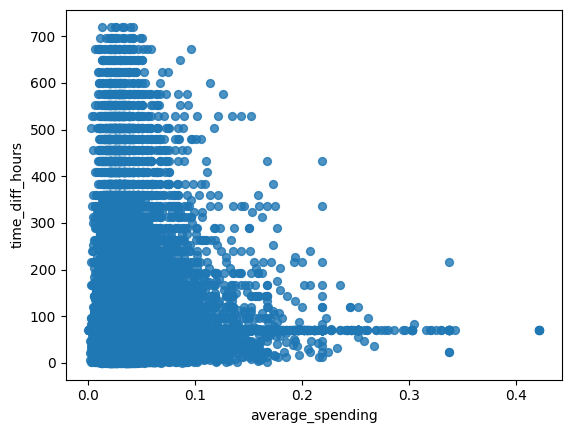

In [19]:
cluster_features = df_c[['average_spending', 'time_diff_hours']]

# Create scatter plot on `time_diff_hours` against `average_spending` for visualisation
cluster_features.plot(kind='scatter', x='average_spending', y='time_diff_hours', s=32, alpha=.8)

In [20]:
# Initialise a standard scaler. As clustering relies on distance between each datapoint, we will need to ensure that
# all features are on the same scale. We use a standard scaler in this case.
scaler = StandardScaler()

# Fit and transform the numerical data
scaled_data = scaler.fit_transform(cluster_features[['average_spending', 'time_diff_hours']])

# Store the scaled data features into a dataframe
scaled_cluster_features = pd.DataFrame(scaled_data, columns=['average_spending', 'time_diff_hours'])

In [21]:
# Convert to numpy array to fit into KMeans algorithm
df_matrix = scaled_cluster_features.to_numpy()

# Choose optimal K using Elbow method
cost = []

# Loop across every possible cluster
for cluster in range(1, 10):
    kmeans = KMeans(n_clusters = cluster, random_state = 0)

    # Fit and predict each customer's cluster
    kmeans.fit_predict(df_matrix)

    # Store the cost, with the element's index being the cluster number
    cost.append(kmeans.inertia_)
    print('Cluster initiation: {}'.format(cluster))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster initiation: 9


In [22]:
# Storing the cost of each cluster into a dataframe
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost':cost})

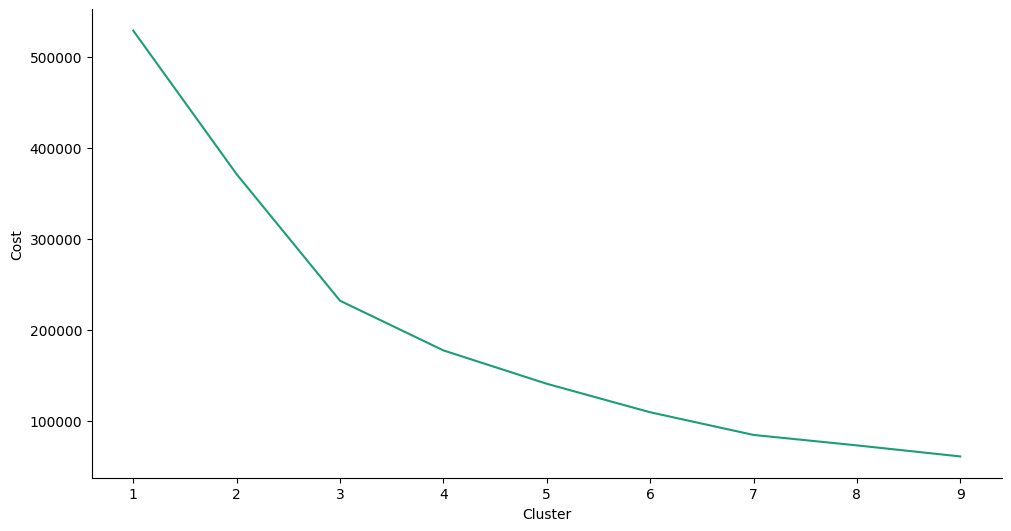

In [23]:
# Plots the cost with respect to the number of clusters
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  # x series
  xs = series['Cluster']
  # y series
  ys = series['Cost']
  # plot
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Sort by ascending order of cluster
df_sorted = df_cost.sort_values('Cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('Cost')

The elbow method is used to determine the optimal number of clusters in a clustering analysis because it provides a straightforward way to evaluate the balance between the complexity of the model (number of clusters) and the model's ability to explain the data variance (fit). In our case, we can see a "elbow-like" shape at cluster 3. Hence, we have determined that there are 3 customer segments from our dataset.

In [24]:
# Using the elbow method, the optimal number of clusters to choose is 3.
kmeans = KMeans(n_clusters = 3, random_state = 0)

# Fits the cluster_features and retrieve the Cluster Assignment predictions of each customer
kmeans.fit_predict(df_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 2, 0, ..., 2, 0, 0], dtype=int32)

In [25]:
cluster_features['cluster'] = kmeans.labels_

<Axes: xlabel='average_spending', ylabel='time_diff_hours'>

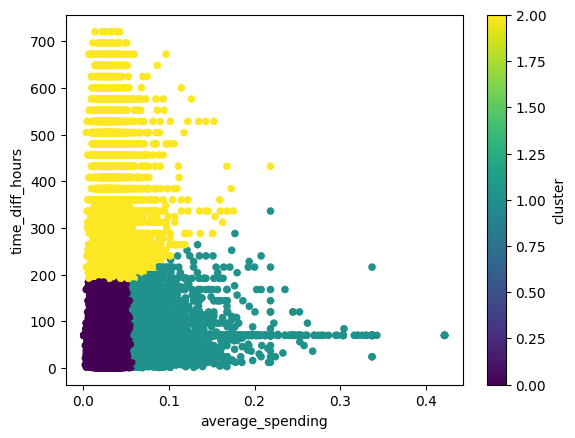

In [26]:
# Plots the scatterplot with cluster labelling to observe cluster behaviour
cluster_features.plot(kind='scatter', x='average_spending', y='time_diff_hours', c = 'cluster', colormap = 'viridis')

## Customer Insights

Observing the plot of the generated clusters, we have already determined that customers can be clustered into 3 segments. We will now need to describe each of the customer cluster and give business insights on what business strategies could be done to increase the sales for each of this cluster.

For each of the cluster, write no more than 3 sentences to describe each cluster with respect to the other clusters. Some example analysis could be, which cluster has the highest average spending and time_diff_hours? What does a low time_diff_hours mean for the business? How should we tackle customers that are in the low `time_diff_hours` zone?



First cluster in purple - frequent low spenders:
These are customers who buy frequently but spend small amounts.
They could maybe benefit from bundling offers or volume discounts to
encourage higher transaction. Maybe a loyalty rewards program could also help maintain their engagement and increase their spending.

Second cluster in teal - moderate spenders who spends regularly:
These are customers who are more balanced with regular spending. They can be targeted with more personalised recomendations based on their purchasing patterns.
Offer maybe early access sales to new products.

Third cluster in yellow - infrequest spenders:
Customers in this group does not buy regularly and spend less. Have to re-engage these customers with targeted marketing campaigns, special offers and personal mails to entice them to come back.


# Recommendation Strategies

Based on the insights you have provided, we implement 3 basic strategies

1. Popular

    Generating the Top K most popular recommendations.

2. Content Based Filtering

    Generating the Top K most similar items to the last purchased item.


3. Collaborative Filtering

    Generating recommendations from the Top K most similar customers in terms of purchase history.



## Popular Recommmendations

Using the freq_purchased feature that we have created earlier, we can retrieve the `Top 10` most popular items across all customers.

In [28]:
df_a_sorted = df_a.sort_values(by='freq_purchased', ascending=False)

top_10_popular_items = df_a_sorted.head(10)

print(top_10_popular_items)

       article_id                 prod_name product_type_name  \
14642   706016001  Jade HW Skinny Denim TRS          Trousers   
10566   673677002           Henry polo. (1)           Sweater   
28560   796210008                     Enter          Trousers   
14644   706016003  Jade HW Skinny Denim TRS          Trousers   
14643   706016002  Jade HW Skinny Denim TRS          Trousers   
25293   772902001                   Haze LS               Top   
9566    660599017              Baraboom (1)          Cardigan   
3670    562245046            Luna skinny RW          Trousers   
10570   673677010            Henry polo (1)           Sweater   
29978   811198001              Peg fineknit           Sweater   

       product_group_name colour_group_name perceived_colour_master_name  \
14642  Garment Lower body             Black                        Black   
10566  Garment Upper body             Black                        Black   
28560  Garment Lower body             Black             

## Content-Based Filtering Recommendations

Using the item embeddings (`tfidf_scores`) that you have generated, let us generate the Top K (default value = 10) most similar items to the `most recent purchased item` of the customer. We will be using the cosine_similarity function.

1. Define the view_last_item_bought function to retrieve the `article_id` of the most recent bought item of a customer.

2. Define the get_content_recommendation function to retrieve the top K most similar items as compared to the last bought item of the user. Use the steps below as a guide.
    
    Step 1: Get the item embedding of the last bought item by the user. First, use the view_last_item_bought function to return the latest bought `article_id`. Next, find the embedding for this `article_id`. This will be your `query_embedding`.
    
    Step 2: Perform the cosine similarity function between your `query_embedding` vector and the entire item embedding matrix (`tfidf_scores`) to retrieve similarity scores between your query_embedding and all the other item embeddings in your matrix.
    
    Step 3: Set any item with a similarity score >= 0.95 to 0 as these will be considered items that are equivalent (perfectly similar) to the query item.
    
    Step 4: Retrieve the Top K = 10 most similar results for the customer with id: 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657. (Hint: Descending order of similarity scores)

In [29]:
def view_last_item_bought(customer_id, df_t):
    customer_transactions = df_t[df_t['customer_id'] == customer_id]
    last_item = customer_transactions.sort_values(by='t_dat', ascending=False).iloc[0]['article_id']
    return last_item

def get_content_recommendation(df_t, df_a, customer_id, tfidf_scores, k=10):

    last_item_id = view_last_item_bought(customer_id, df_t)

    item_idx = df_a[df_a['article_id'] == last_item_id].index[0]

    query_embedding = tfidf_scores[item_idx]

    similarity_scores = cosine_similarity(query_embedding, tfidf_scores).flatten()

    similarity_scores[similarity_scores >= 0.95] = 0

    similar_item_indices = similarity_scores.argsort()[-k:][::-1]

    recommended_items = df_a.iloc[similar_item_indices]

    return recommended_items


In [30]:
content_recommendations = get_content_recommendation(df_t, df_a, '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657', tfidf_scores)
print(content_recommendations)

       article_id        prod_name product_type_name  product_group_name  \
5817    608769002         Bugg (2)            Blazer  Garment Upper body   
19490   740791001     Raven blazer            Blazer  Garment Upper body   
4057    568601033         Mariette            Blazer  Garment Upper body   
4058    568601034         Mariette            Blazer  Garment Upper body   
4054    568601029         Mariette            Blazer  Garment Upper body   
4052    568601023  Mariette Blazer            Blazer  Garment Upper body   
4049    568601008         Mariette            Blazer  Garment Upper body   
4056    568601031         Mariette            Blazer  Garment Upper body   
4047    568601006  Mariette Blazer            Blazer  Garment Upper body   
4050    568601016         Mariette            Blazer  Garment Upper body   

      colour_group_name perceived_colour_master_name index_group_name  \
5817              Black                        Black       Ladieswear   
19490        Ligh

## User-Based Collaborative Filtering Recommendations

For this recommendation strategy, we will be performing User-based Collaborative Filtering where recommendations are generated from the `most popular` interactions by the `most similar` customers as compared to the query customer. We will consider only neighbours that have a similarity score (>= 0.6) which represents a high similarity in customer behaviour with respect to the query customer. Among these similar neighbours, We will then perform a majority voting on the most interacted items. The most popular items among the similar neighbours are recommended to the customer. `Take note, the recommended items have to be items that have not been interacted by the customer in the past.`


### Creating the user-item interactions dataframe

In [31]:
# create the user-item interactions dataframe
user_item_interactions = df_t.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')

# Display the user-item interactions
print(user_item_interactions.head())

                                         customer_id  article_id  frequency
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   797065001          2
1  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   399061015          2
2  000064249685c11552da43ef22a5030f35a147f723d5b0...   680265002          1
3  000064249685c11552da43ef22a5030f35a147f723d5b0...   738133005          1
4  000064249685c11552da43ef22a5030f35a147f723d5b0...   740962001          1


### Preparing the similarity matrix

Step 1: Using the LabelEncoder library from sklearn, run the fit_transform method to fit and transform the `customer_id` column and `article_id` column into indexes. Create new columns for each of these indexes, `user_idx` and `item_idx` respectively in the `user_item_interactions` dataframe. These indexes will be needed to generate the affinity (user-item) matrix where the indexes can be referenced back to the customer_id and article_id format easily.

Step 2: Using the `user_item_interactions` dataframe you have defined in Task 5.3.1, create a sparse affinity (user-item) matrix using the scipy.sparse library. The rows represent the user encoded index, columns represent every article index in `df_a`. Each element is represented with a 1 if the user has purchased the item, and 0 if the user has not.

Step 3: Call the sklearn's cosine_similarity function on the sparse affinity (user-item) matrix to find the most similar neighbouring customers (in terms of purchase behaviour) for each customer.

In [32]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

user_item_interactions['user_idx'] = user_encoder.fit_transform(user_item_interactions['customer_id'])
user_item_interactions['item_idx'] = item_encoder.fit_transform(user_item_interactions['article_id'])

user_item_matrix = csr_matrix((user_item_interactions['frequency'],
                               (user_item_interactions['user_idx'], user_item_interactions['item_idx'])))


In [37]:
from scipy.sparse import vstack, csr_matrix

def calculate_similarity_in_batches(user_item_matrix, batch_size=5000):
    user_similarity_matrices = []

    num_users = user_item_matrix.shape[0]

    for start in range(0, num_users, batch_size):
        end = min(start + batch_size, num_users)
        batch = user_item_matrix[start:end]

        user_similarity_batch = cosine_similarity(batch, user_item_matrix, dense_output=False)

        user_similarity_matrices.append(user_similarity_batch)

    user_similarity_matrix = vstack(user_similarity_matrices)

    return user_similarity_matrix

user_similarity_matrix = calculate_similarity_in_batches(user_item_matrix, batch_size=5000)

print(user_similarity_matrix.shape)

(264401, 264401)


### Generating user-based collaborative filtering recommendations

Function takes the arguments user_similarity_matrix which has been defined in the previous task, customer_id as the customer we want to generate recommendations for, k = 10 which represents the top 10 recommendations generated, and sim_threshold = 0.6 which represents any customer that has a similarity score >= 0.6 is considered a similar customer and will be included in the majority voting process

Step 1: Encode the customer_id to retrieve the index of the customer you are generating recommendations for. Also, find out the list of article_ids that have already been interacted by the query customer. (0.3 marks)

Step 2: Index `user_similarity_matrix` to find retrieve all the similarity scores between the queried user and all other customers (0.3 marks)

Step 3: Filter `away` users who have perfect similarity scores (>= 0.95) as there are no new items to recommend to the query customer. (0.3 marks)

Step 4: We will use a default threshold similarity of 0.6. Filter only neighbours that have similarity scores >= 0.6. (0.3 marks)

Step 5: With the help of the defined `user_item_interactions` dataframe, find the most interacted items that were interacted by the most similar neighbours (defined in Step 3 and 4). (0.3 marks)

Step 6: Generate the Top 10 (most interacted by neighbours) recommendations for the customer with id (this is the query customer): `00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657` (0.2 marks)


In [44]:
def get_collaborative_filtering_recommendations(user_similarity_matrix, customer_id, k=10, sim_threshold=0.6):
    # 1
    customer_idx = user_encoder.transform([customer_id])[0]
    interacted_items = user_item_interactions[user_item_interactions['user_idx'] == customer_idx]['item_idx'].values

    # 2
    customer_similarities = user_similarity_matrix[customer_idx].toarray().flatten()

    # 3
    customer_similarities[customer_similarities >= 0.95] = 0

    # 4
    similar_customers = np.where(customer_similarities >= sim_threshold)[0]

    # 5
    similar_customers_items = user_item_interactions[user_item_interactions['user_idx'].isin(similar_customers)]

    new_recommendations = similar_customers_items[~similar_customers_items['item_idx'].isin(interacted_items)]
    top_recommendations = new_recommendations.groupby('item_idx').sum().sort_values(by='frequency', ascending=False).head(k)
    recommended_article_ids = item_encoder.inverse_transform(top_recommendations.index)

    recommended_items = df_a[df_a['article_id'].isin(recommended_article_ids)]

    return recommended_items


In [43]:
# This function should work
items_to_recommend = get_collaborative_filtering_recommendations(user_similarity_matrix, '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657')
items_to_recommend

,article_id,prod_name,product_type_name,product_group_name,colour_group_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,freq_purchased,combined_desc
3264,554598001,Nora T-shirt,T-shirt,Garment Upper body,Black,Black,Ladieswear,Jersey Basic,"T-shirt in soft jersey with a round neck, shor...",383,T-shirt Black Ladieswear Jersey Basic
4038,568597006,Hayes slim trouser,Trousers,Garment Lower body,Black,Black,Ladieswear,Trousers,Suit trousers in a stretch weave with a regula...,1103,Trousers Black Ladieswear Trousers
4047,568601006,Mariette Blazer,Blazer,Garment Upper body,Black,Black,Ladieswear,Dressed,Fitted jacket in woven fabric with notch lapel...,1594,Blazer Black Ladieswear Dressed
4065,568808001,Vermont Summer Slacks,Trousers,Garment Lower body,Black,Black,Ladieswear,Trousers,"Ankle-length, tailored trousers in woven fabri...",324,Trousers Black Ladieswear Trousers
4567,578487002,Burmilla (1),Blazer,Garment Upper body,Black,Black,Ladieswear,Dressed,Straight-cut jacket in woven fabric with notch...,88,Blazer Black Ladieswear Dressed
10713,675068002,Melrose,Shirt,Garment Upper body,White,White,Ladieswear,Blouses,Straight-cut shirt in an airy cotton weave wit...,171,Shirt White Ladieswear Blouses
25964,778204001,Ice landic blazer,Blazer,Garment Upper body,Black,Black,Ladieswear,Dressed,"Fitted, single-breasted jacket in woven fabric...",186,Blazer Black Ladieswear Dressed
27732,789772001,Isabella shirt,Shirt,Garment Upper body,White,White,Ladieswear,Blouses,Fitted shirt in a stretch weave made from a co...,1071,Shirt White Ladieswear Blouses
28460,795675001,Gabbi tank/nina/nelia,Vest top,Garment Upper body,Black,Black,Divided,Jersey Basic,Fitted vest top in stretch cotton jersey.,632,Vest top Black Divided Jersey Basic
28461,795675003,Gabbi tank/nina/nelia,Vest top,Garment Upper body,White,White,Divided,Jersey Basic,Fitted vest top in stretch cotton jersey.,225,Vest top White Divided Jersey Basic


# Final Insights


There three main customer segments: **frequent low spenders**, **moderate spenders with regular purchases**, and **infrequent low spenders**.

#### **1. frequent low spenders **:
- popular recommendations: will work for this group because they are frequent shoppers but tend to spend less. Popular items are often affordable and trendy, which aligns with their shopping behavior. However, since they already shop frequently, they may quickly become disengaged if recommendations lack variety.

- content based filtering: could benefit from content-based filtering since it personalizes recommendations based on their past purchases. Offering similar, low-cost items could encourage continued frequent purchases while maintaining relevance to their preferences.

- collaborative filtering: may also be effective for this group, as they share shopping patterns with other frequent buyers. Recommending items popular among similar low spenders could introduce them to new affordable products they may not have discovered.

Best will be collaborative filtering  because this group shares behaviors with many other frequent shoppers, recommending items popular with similar customers is likely to keep them engaged while encouraging continuous purchases.

---

#### **2. moderate spenders with regular purchases **:
- popular recommendations: less effective for moderate spenders, as they may prefer a more personal shopping experience and may not respond as well to items that appeal to the masses.

- content based filtering : likely to be very effective for this group. Moderate spenders who shop regularly will appreciate receiving recommendations that are based on their specific past purchases. Personalized recommendations, such as suggesting higher-quality or complementary items to their previous purchases, can increase the value of each transaction.

- collaborative filtering : may work well for moderate spenders as well, since they could benefit from discovering items that other similar customers are purchasing. However, the recommendations need to align with their spending habits, focusing on mid-range products.

Best is moderate spenders will benefit the most from personalized recommendations that target their past behavior, allowing for a more tailored shopping experience and encouraging higher-value purchases (content based filtering)

---

#### **3. infrequent low spenders **:
- popular recommendations: might be effective here because this segment tends to spend less and may be attracted by popular, affordable items. Popular items often represent low-risk choices, which may appeal to customers who shop infrequently.
- content based filtering: less effective here, as their infrequent purchases provide limited data to generate relevant recommendations. Their low engagement means personalized recommendations may not hold much sway over their decisions.
- collaborative filtering: could work, but only if there are enough similar customers to find good matches. However, because they are infrequent shoppers, collaborative filtering might recommend items that don’t necessarily match their irregular shopping habits.

best is infrequent shoppers are drawn to popular items because these items are generally low-risk and widely accepted. It also requires minimal personalization, which aligns with their lower engagement.

---